# Homework - DINO
### Sharif University - Deep Learning Course - Spring 2024

*Instructor:  Dr. Soleymani*

---

*Full Name: Payam Taebi* 

*SID: 400104867*

---

In this homework we will learn to use the DINO model.

In this homework you need to complete the notebook and run all the cells.
We have specified the parts to be completed with `TODO` tags inside the code blocks.

**NOTES**:
* It is important that you read all the code and text blocks carefully, even if you think you are excited to jump into completing the missing codes.
* This notebook is tested with *Google Colab* and *Kaggle* free runtimes and you can used them for testing your code.
* Ensure all cells are executable and perform their intended functions
* You can ask your questions on [Quera Class](https://quera.org/course/16605/)
* Write clear, commented code when necessary.

# Introduction

Listen up, folks! You know how they say dinosaurs are extinct? Well, they lied to us. The DINO model is proof that these ancient beasts are still roaming the earth, but this time, they're here to help us with feature extraction and downstream tasks. Imagine a T-Rex with a fancy deep learning algorithm strapped to its back, stomping around and making sense of all the data in its path.

But wait, it gets better! This dino doesn't just extract features; it does it in a self-supervised manner, which means it's like a kid who learned to tie its own shoelaces without any help from its parents (or, in this case, labeled data). And once it's done extracting those juicy features, it's ready to tackle any downstream task you throw its way, whether it's image classification, object detection, or even predicting the next hot dinosaur-themed movie.

In this homework assignment, we will be utilizing the DINO model to extract meaningful visual features from satellite imagery data. The self-supervised DINO model has proven to be an effective tool for extracting rich representations from visual data without the need for labeled examples during pre-training.

Specifically, we will leverage the DINO model's capabilities to extract visual features from satellite images. These extracted features will then be used to train a classifier on top of the DINO backbone. The goal of this classifier is to predict whether a given satellite image contains solar panels or not.

Moving on to the second part of the assignment, we will explore the transformer attention maps produced by the DINO model. By analyzing these attention maps, we aim to estimate the size of the solar panels present in the positive examples from the dataset.

While not as exhilarating as envisioning a dinosaur with deep learning capabilities, this assignment presents an opportunity to gain hands-on experience with a state-of-the-art self-supervised model and its applications in computer vision tasks. I'm sure you'll find the process insightful and rewarding.

# Installations and imports

As usual, imports are our first step.

In [1]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.4 MB/s eta 0:00:00


In [2]:
!pip install rasterio

In [3]:
import glob
import torch
import rasterio
import numpy as np
import einops as eo
import random as rnd
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib.colors import Normalize
from torch.utils.data import Dataset, DataLoader


# Dataset

In [4]:
!pip install gdown

In [5]:
!gdown https://drive.google.com/uc?id=1AgBzfGrOSEcuItEGBv7VpSw6bfJBichK

Downloading...
From (original): https://drive.google.com/uc?id=1AgBzfGrOSEcuItEGBv7VpSw6bfJBichK
From (redirected): https://drive.google.com/uc?id=1AgBzfGrOSEcuItEGBv7VpSw6bfJBichK&confirm=t&uuid=96c35807-6005-4f44-901b-83911610a521
To: /kaggle/working/uk20K.zip
100%|███████████████████████████████████████| 1.92G/1.92G [00:16<00:00, 114MB/s]


In [6]:
# Move the dataset to this colab session.
# We suggest you add a shortcut from the given file to your own google drive account and then copy the file from that shortcut to here.

# ======================= Your Code =======================
#NO NEED
# ======================= Your Code =======================

In [7]:
!unzip -q uk20K.zip

Let's prepare the train and validation datasets.

In [8]:
def normalize(image, MEAN = [0.485, 0.456, 0.406], STD = [0.485, 0.456, 0.406]):
    image = image / 255
    source, dest = 0 if len(image.shape) == 3 else 1, -1
    return np.moveaxis((np.moveaxis(image, source, dest) - MEAN) / STD, dest, source)

def denormalize(image, MEAN = [0.485, 0.456, 0.406], STD = [0.485, 0.456, 0.406]):
    source, dest = 0 if len(image.shape) == 3 else 1, -1
    image = np.moveaxis((np.moveaxis(image, source, dest) * STD) + MEAN, dest, source)
    return (image * 255).astype(int)


class SolarDataset(Dataset):
    def __init__(self, file_names):
        self.file_names = file_names

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        path = self.file_names[index]
        x = rasterio.open(self.file_names[index]).read()
        y = torch.tensor(1.0).long() if path.endswith('-P.tif') else torch.tensor(0.0).long()
        x = normalize(x, MEAN=[0.5, 0.5, 0.5], STD=[0.5, 0.5, 0.5])
        return torch.as_tensor(x.copy()).float(), y, self.file_names[index]

The dataset comprises of .tif image files. The images are labeled based on the presence or absence of solar panels within them. If an image's filename ends with "-P" it indicates a positive label, signifying that the image contains at least one solar panel. Conversely, if the filename ends with "-N" it denotes a negative label, implying that no solar panels are present in the image. However, the dataset does not provide any details regarding the size of the solar panels in the images.

Split the dataset into train and test sets and create the dataloaders.

In [9]:
# ======================= Your Code =======================
import os
from torch.utils.data import Dataset, DataLoader, random_split
dataset = SolarDataset([os.path.join('./uk20K_v2', f) for f in os.listdir('./uk20K_v2') if f.endswith('.tif')])
# ======================= Your Code =======================

In [10]:
# ======================= Your Code =======================
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ======================= Your Code =======================

print(len(train_dl), len(val_dl))

500 125


# Model definition

This section focuses on defining the models. The first component is a DINO backbone, which serves as a feature extractor. The code for DINO is already written and does not require any modifications. The second component is a classifier head that will be placed on top of the DINO features. The init function for this model has been provided, and your task is to complete the forward method.

In [11]:
class DinoBackbone(nn.Module):
    def __init__(self, dino_size='small') -> None:
        super().__init__()
        if dino_size == 'small':
            self.dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
            self.d_model = 384
        elif dino_size == 'base':
            self.dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
            self.d_model = 768
        elif dino_size == 'giant':
            self.dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')
            self.d_model = 1536

    def forward(self, x):
        x = self.dinov2.forward_features(x)
        cls_token = x["x_norm_clstoken"]
        patch_tokens = x["x_norm_patchtokens"]
        return cls_token, patch_tokens

In [12]:
class TransformerEncoderLinearHead(nn.Module):

    def __init__(self, d_model, output_size) -> None:
        super().__init__()
        self.transformer = nn.TransformerEncoderLayer(d_model, 8, batch_first=True)
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x_feats):
        cls_embs, patch_embs = x_feats

        # 1. Combine cls and patch embeddings into a single sequence
        combined_embs = torch.cat((cls_embs.unsqueeze(1), patch_embs), dim=1)

        # 2. Pass through the transformer layer
        transformer_output = self.transformer(combined_embs)

        # 3. Pass the cls output (first token) of the transformer to the linear layer
        cls_output = transformer_output[:, 0, :]
        output = self.fc(cls_output)

        # 4. Return the output of the linear model as the prediction
        return output

    def get_size_estimate(self, x_feats, vis=False, images=None):
        cls_embs, patch_embs = x_feats

        # 1. Combine cls and patch embeddings into a single sequence
        combined_embs = torch.cat((cls_embs.unsqueeze(1), patch_embs), dim=1)

        # 2. Pass through the self-attention layer of the transformer and get attention weights
        self_attention_output = self.transformer.self_attn(combined_embs, combined_embs, combined_embs, need_weights=True,average_attn_weights=False)
        attention_weights = self_attention_output[1]  # shape: (batch_size, num_heads, seq_length, seq_length)

        # 3. Get the attention of each token with all other tokens (shape: hx257x257 where h is the number of heads)
        # 4. Get the attention score of cls token with all patch tokens (shape: hx256)
        cls_attention = attention_weights[:, :, 0, 1:]  # shape: (batch_size, num_heads, 256)

        # 5. Reshape this into hx16x16
        cls_attention_reshaped = cls_attention.view(cls_attention.shape[0], cls_attention.shape[1], 16, 16)

        # 6. Upsample this 16x16 image by a factor of 14 (You get a hx224x224 image)
        #upsampled_attention = torch.nn.functional.interpolate(cls_attention_reshaped, scale_factor=14, mode='bilinear', align_corners=False)
        upsampled_attention = cls_attention_reshaped.repeat_interleave(14, dim=2).repeat_interleave(14, dim=3)
        
        # 7. Sum across the heads (shape: 224x224)
        attention = upsampled_attention.sum(dim=1)  # shape: (batch_size, 224, 224)

        # 8. Normalize this 224x224 into the [0,1] range for all pixels
        normalized_attention = (attention - attention.min()) / (attention.max() - attention.min())

        # 9. Create a binary mask from this 224x224 using a threshold (You should choose this threshold)
        threshold = 0.37  # Example threshold, you may need to adjust this
        binary_mask = (normalized_attention > threshold).cpu().float()

        # 10. This mask is an estimation of the solar panels in the image (if it exists). You can use it to estimate the size of the solar panel
        
        h, w = binary_mask.shape[-2:]
        visualization_images = []
        if vis:
            for i in range(images.shape[0]):
                img = images[i].detach().cpu().numpy().transpose((1, 2, 0))
                normalized_img = Normalize(vmin=img.min(), vmax=img.max())(img)

                reds = plt.cm.Reds(binary_mask[i])
                alpha_max_value = 1.00
                gamma = 0.5

                rgba_img = np.zeros((h, w, 4))
                rgba_img[..., :3] = normalized_img
                rgba_img[..., 3] = 1

                rgba_mask = np.zeros((h, w, 4))
                rgba_mask[..., :3] = reds[..., :3]
                rgba_mask[..., 3] = np.power(binary_mask[i], gamma) * alpha_max_value

                rgba_all = np.zeros((h, 2*w, 4))
                rgba_all[:, :w, :] = rgba_img
                rgba_all[:, w:, :] = rgba_mask

                visualization_images.append(rgba_all)

        counts = binary_mask.sum((1, 2))
        return counts, visualization_images

# Train

Now initialize the model, define the optimizer and loss function and train the classifier model. Train your model for 2 epochs (this should be pretty fast). Pay attention that your code produces similar output as the one in the notebook so that training loss and validation accuracy are reported.

In [13]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

backbone = DinoBackbone(dino_size='small')
backbone = backbone.to(device)
backbone.eval()
head = TransformerEncoderLinearHead(backbone.d_model, 2)
head = head.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_reg4_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 229MB/s]


In [14]:
lr = 0.001
optimizer = torch.optim.Adam(head.parameters(), lr=lr)

In [15]:
iter = 0
running_loss = 0
n_epoch = 10

for epoch in range(n_epoch):
    for i, (inputs, labels, _) in enumerate(train_dl):
        iter += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        # ==================== Your Code ====================
        with torch.no_grad():
            # Extract the DINO features
            features = backbone(inputs)
        
        # Forward pass through the classifier
        outputs = head(features)
        loss = F.cross_entropy(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ==================== Your Code ====================
        
        running_loss += loss.item()
    
        if iter % 10 == 0:  # Print every 10 batches
            print(f'Epoch [{epoch+1}], Iteration [{iter}], Loss: {running_loss/10:.4f}')
            running_loss = 0

torch.save(head.state_dict(), 'final_model.pth')


Epoch [1], Iteration [10], Loss: 0.8569
Epoch [1], Iteration [20], Loss: 0.4070
Epoch [1], Iteration [30], Loss: 0.2494
Epoch [1], Iteration [40], Loss: 0.1991
Epoch [1], Iteration [50], Loss: 0.2459
Epoch [1], Iteration [60], Loss: 0.2270
Epoch [1], Iteration [70], Loss: 0.1765
Epoch [1], Iteration [80], Loss: 0.2553
Epoch [1], Iteration [90], Loss: 0.3024
Epoch [1], Iteration [100], Loss: 0.2125
Epoch [1], Iteration [110], Loss: 0.2305
Epoch [1], Iteration [120], Loss: 0.2518
Epoch [1], Iteration [130], Loss: 0.2544
Epoch [1], Iteration [140], Loss: 0.2584
Epoch [1], Iteration [150], Loss: 0.2431
Epoch [1], Iteration [160], Loss: 0.2052
Epoch [1], Iteration [170], Loss: 0.1955
Epoch [1], Iteration [180], Loss: 0.1948
Epoch [1], Iteration [190], Loss: 0.2300
Epoch [1], Iteration [200], Loss: 0.2369
Epoch [1], Iteration [210], Loss: 0.2185
Epoch [1], Iteration [220], Loss: 0.1576
Epoch [1], Iteration [230], Loss: 0.2353
Epoch [1], Iteration [240], Loss: 0.2737
Epoch [1], Iteration [250

In [16]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    total_loss = 0

    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Extract the DINO features
            features = backbone(inputs)
            
            # Forward pass through the classifier
            outputs = model(features)
            loss = F.cross_entropy(outputs, labels)
            
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Evaluation
avg_loss, accuracy = evaluate_model(head, val_dl, device)
print(f'Evaluation Loss: {avg_loss}, Accuracy: {accuracy}')


Evaluation Loss: 0.17376493108272553, Accuracy: 0.9305


In [17]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

backbone = DinoBackbone(dino_size='small')
backbone = backbone.to(device)
backbone.eval()
head = TransformerEncoderLinearHead(backbone.d_model, 2)
head.load_state_dict(torch.load('final_model.pth'))
head = head.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Now go through the validation set and for every image predict whether it contains solar panel or not. Then from all the images that contain solar panels, visualize some that have the large panels and some with the small panels based on your size estimation module. Your outputs should be something like the following. Remeber: you have to look at size estimates only for images that are predicted positive (contain solar panel.) The size estimation module doesn't work for negative images (There are no panels to estimate their size).

In [18]:
def evaluate_model(backbone, head, dataloader, device, max_small_panels=10, max_large_panels=3, small_panel_range=(150, 200), large_panel_threshold=1000):
    backbone.eval()
    head.eval()
    
    correct = 0
    total = 0
    small_panels = []
    large_panels = []
    small_count = 0
    large_count = 0

    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            #print(labels)

            # Extract the DINO features
            dino_features = backbone(inputs)

            # Forward pass through the classifier
            outputs = head(dino_features)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            count, img = head.get_size_estimate(dino_features, vis=True, images=inputs)

            for i in range(len(img)):
                if predicted[i] == 1 and small_panel_range[0] < count[i] < small_panel_range[1]:
                    if small_count < max_small_panels:
                        small_count += 1
                        small_panels.append((count[i], img[i] if isinstance(img[i], np.ndarray) else img[i].cpu().numpy()))
                elif predicted[i] == 1 and count[i] > large_panel_threshold:
                    if large_count < max_large_panels:
                        large_count += 1
                        large_panels.append((count[i], img[i] if isinstance(img[i], np.ndarray) else img[i].cpu().numpy()))

                if small_count >= max_small_panels and large_count >= max_large_panels:
                    break

            if small_count >= max_small_panels and large_count >= max_large_panels:
                break

    accuracy = correct / total * 100
    return accuracy, small_panels, large_panels

def plot_panels(panel_type, panels):
    print(f"Plotting the {panel_type} panels:")
    for count, image in panels:
        print(count)
        plt.imshow(image)
        plt.show()
        
        
max_small_panels = 10
max_large_panels = 10

small_panel_range = (150, 200)
large_panel_threshold = 1000

accuracy, small_panels, large_panels = evaluate_model(backbone, head, val_dl, device, max_small_panels, max_large_panels, small_panel_range, large_panel_threshold)

print(f'Accuracy: {accuracy}%')

Accuracy: 91.25%


Plotting the large panels:
tensor(1372.)


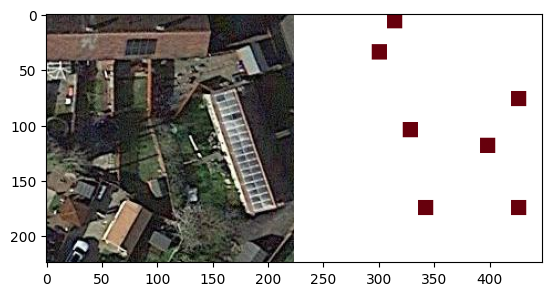

tensor(1176.)


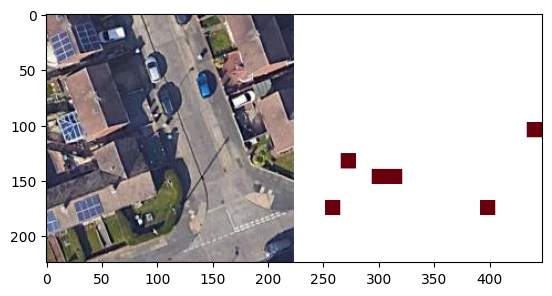

tensor(1372.)


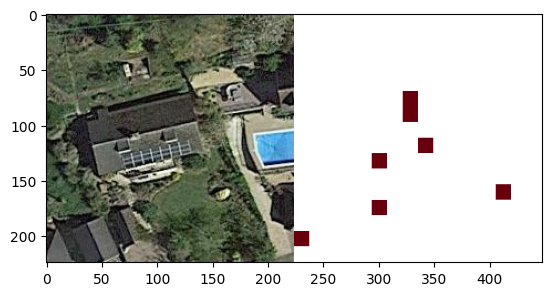

tensor(1176.)


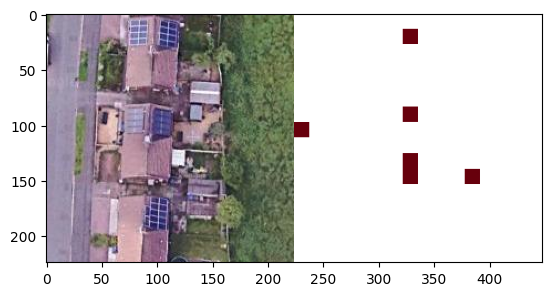

tensor(1176.)


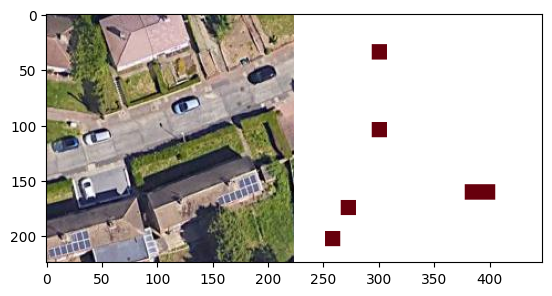

tensor(1176.)


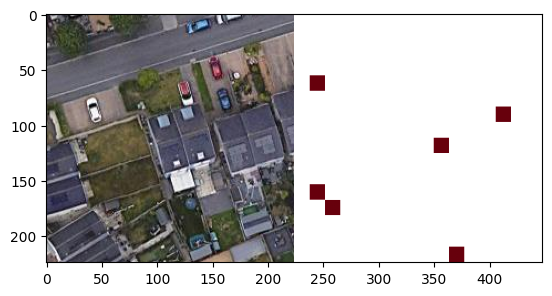

tensor(1176.)


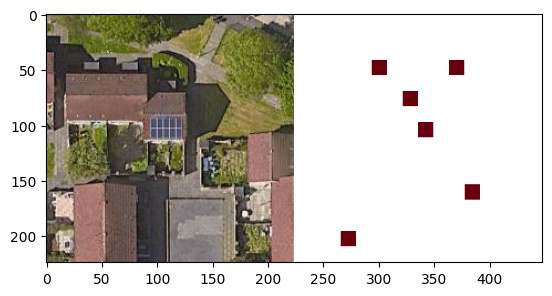

tensor(1176.)


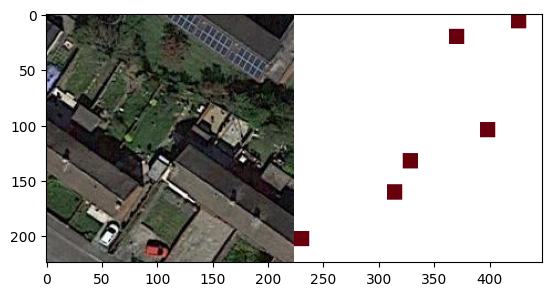

tensor(1176.)


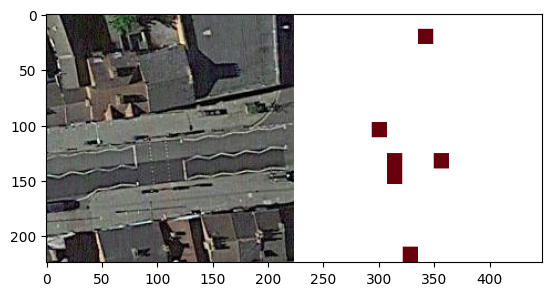

tensor(1372.)


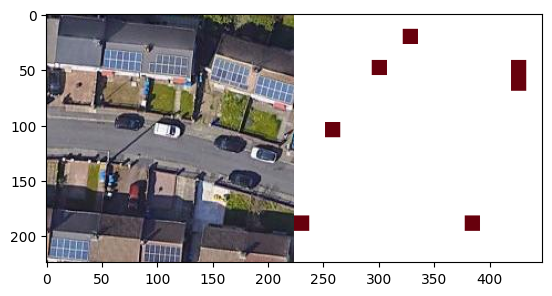

In [19]:
plot_panels("large", large_panels)

Plotting the small panels:
tensor(196.)


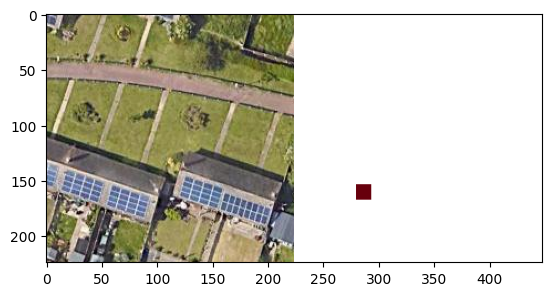

tensor(196.)


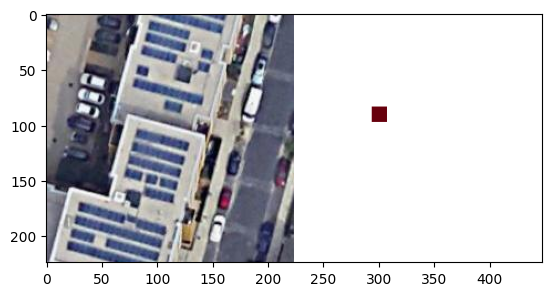

tensor(196.)


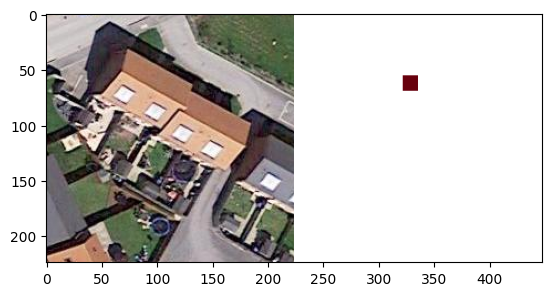

tensor(196.)


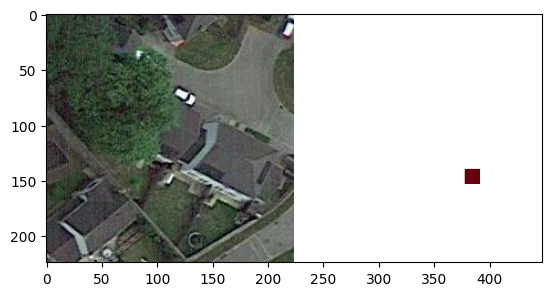

tensor(196.)


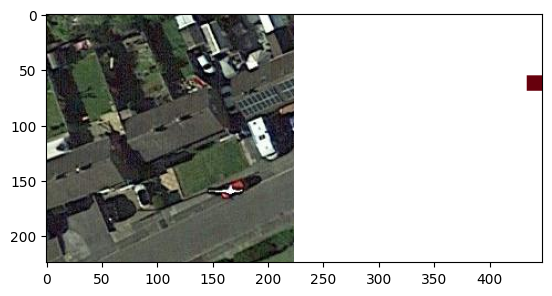

tensor(196.)


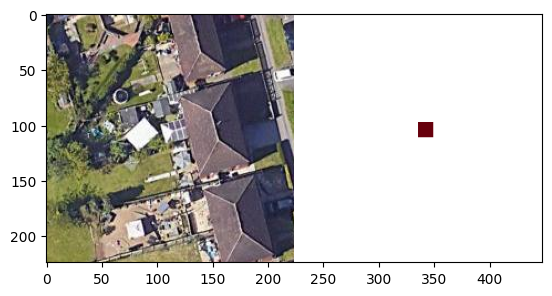

tensor(196.)


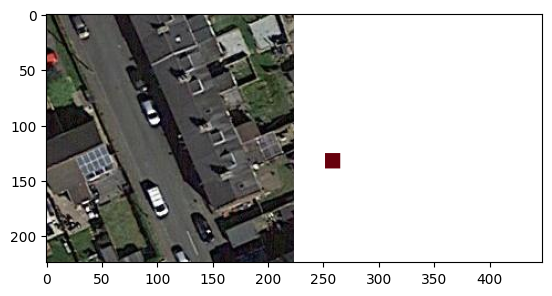

tensor(196.)


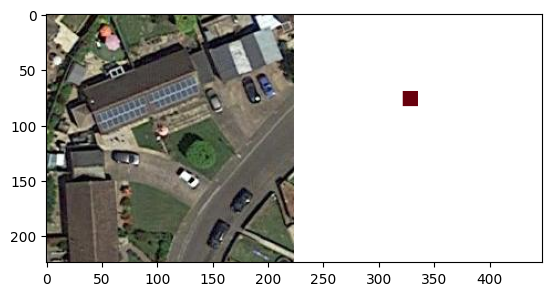

tensor(196.)


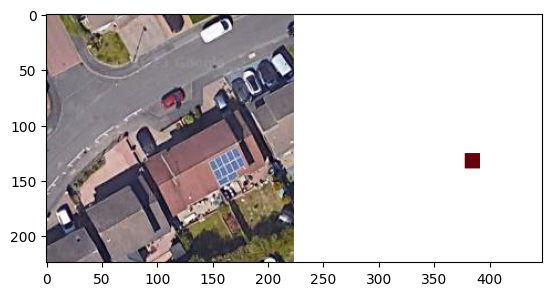

tensor(196.)


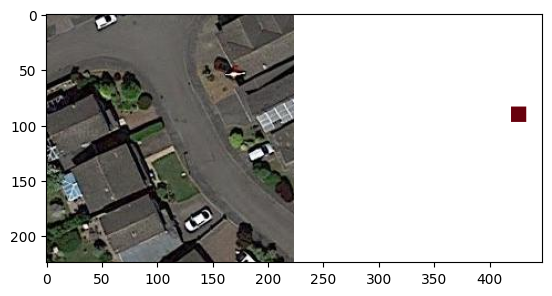

In [20]:
plot_panels("small", small_panels)